In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
import datetime
from sklearn.preprocessing import PolynomialFeatures
from scipy.optimize import curve_fit
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('RSV-Deprivation-Data-v2.csv')
data

,AdmissionTime,DischargeTime,LengthOfSpell,Index of Multiple Deprivation Decile,Health Deprivation and Disability Decile
0,2017/7/25 1:25,2017/7/31 17:27,6,NaN,NaN
1,2017/8/3 0:31,2017/8/5 19:23,2,1.0,1.0
2,2017/8/5 18:37,2017/10/13 17:27,69,2.0,2.0
3,2017/8/8 16:20,2017/8/8 20:30,0,NaN,NaN
4,2017/8/11 17:05,2017/8/17 17:55,6,2.0,2.0
...,...,...,...,...,...
2121,2022/7/11 11:01,2022/7/12 8:57,1,5.0,5.0
2122,2022/7/12 0:24,2022/7/13 19:36,1,3.0,2.0
2123,2022/7/12 11:31,2022/7/12 16:30,0,4.0,4.0
2124,2022/7/12 21:45,2022/7/13 20:10,1,2.0,2.0


In [3]:
# Count null values
a = pd.DataFrame(data['Health Deprivation and Disability Decile'])
b = pd.DataFrame(data['DischargeTime'])
print(len(a[a.isnull().T.any()]))
print(len(b[b.isnull().T.any()]))

108
11


## Data Preprocessing

In [4]:
# drop null value
data = data.dropna()
data = data.reset_index(drop=True)
# change to date time type
data['AdmissionTime'] = pd.to_datetime(data['AdmissionTime'],format='%Y/%m/%d')
data['DischargeTime'] = pd.to_datetime(data['DischargeTime'],format='%Y/%m/%d')
# extract year and month to a new column
data['YearMonth'] = data['AdmissionTime'].dt.to_period('M')
# change to integer
data['Index of Multiple Deprivation Decile'] = data['Index of Multiple Deprivation Decile'].astype(int)
data['Health Deprivation and Disability Decile'] = data['Health Deprivation and Disability Decile'].astype(int)
# add a column to show how many hours the patient stay in hospital
hours = []
for i in range(len(data)):
    hours.append(round((data['DischargeTime'][i].timestamp()-data['AdmissionTime'][i].timestamp())/3600,2))
data['LengthOfSpellHours'] = hours
# rearrange the dataframe
df = pd.DataFrame({'AdmissionTime':data['AdmissionTime'], 'DischargeTime':data['DischargeTime'], 'YearMonth':data['YearMonth'], 'LengthOfSpellHours':data['LengthOfSpellHours'], 'Index of Multiple Deprivation Decile':data['Index of Multiple Deprivation Decile'], 'Index of Health Deprivation and Disability Decile':data['Health Deprivation and Disability Decile']})
print(len(df),'pieces of data in total')
df.head()

2007 pieces of data in total


,AdmissionTime,DischargeTime,YearMonth,LengthOfSpellHours,Index of Multiple Deprivation Decile,Index of Health Deprivation and Disability Decile
0,2017-08-03 00:31:00,2017-08-05 19:23:00,2017-08,66.87,1,1
1,2017-08-05 18:37:00,2017-10-13 17:27:00,2017-08,1654.83,2,2
2,2017-08-11 17:05:00,2017-08-17 17:55:00,2017-08,144.83,2,2
3,2017-08-17 21:56:00,2017-08-19 10:30:00,2017-08,36.57,1,1
4,2017-08-20 23:54:00,2017-08-22 14:31:00,2017-08,38.62,8,8


In [5]:
# File 7: all ranks, deciles and scores for the indices of deprivation, and population denominators
deprivation = pd.read_csv('governmentData.csv')
deprivation = deprivation.iloc[:, [1, 3, 6, 18, -5]]
deprivation.columns = ['LSOA', 'LAD', 'IMD', 'IHDD', 'POPULATION']
deprivation
greaterMan = ['Bolton', 'Bury', 'Oldham', 'Rochdale', 'Stockport', 'Tameside', 'Trafford', 'Wigan', 'Salford', 'Manchester']
greaterManData = []
for i in range(len(deprivation)):
    if deprivation['LAD'][i] in greaterMan:
        greaterManData.append(deprivation.loc[i])
greaterManDF = pd.DataFrame(greaterManData)
greaterManDF

,LSOA,LAD,IMD,IHDD,POPULATION
4642,Bolton 005A,Bolton,3,3,1616
4643,Bolton 005B,Bolton,4,4,1777
4644,Bolton 001A,Bolton,9,7,1546
4645,Bolton 003A,Bolton,8,5,1459
4646,Bolton 003B,Bolton,7,5,1436
...,...,...,...,...,...
32759,Manchester 013F,Manchester,6,2,1779
32760,Manchester 003F,Manchester,4,3,1490
32761,Manchester 028F,Manchester,2,1,1170
32762,Manchester 003G,Manchester,1,1,1759


In [6]:
manchester = df[df['LengthOfSpellHours']>1]
print(len(manchester))
manchester.head()

1999


,AdmissionTime,DischargeTime,YearMonth,LengthOfSpellHours,Index of Multiple Deprivation Decile,Index of Health Deprivation and Disability Decile
0,2017-08-03 00:31:00,2017-08-05 19:23:00,2017-08,66.87,1,1
1,2017-08-05 18:37:00,2017-10-13 17:27:00,2017-08,1654.83,2,2
2,2017-08-11 17:05:00,2017-08-17 17:55:00,2017-08,144.83,2,2
3,2017-08-17 21:56:00,2017-08-19 10:30:00,2017-08,36.57,1,1
4,2017-08-20 23:54:00,2017-08-22 14:31:00,2017-08,38.62,8,8


In [7]:
population = pd.read_csv('population.csv')
population = population[population['Local Authority District name (2019)'] == 'Manchester']
totalPop = sum([int(x.replace(',','')) for x in population['Total population: mid 2015 (excluding prisoners)']])
age0_15 = sum([int(x.replace(',','')) for x in population['Dependent Children aged 0-15: mid 2015 (excluding prisoners)']])
print('Total population in Manchester: ', totalPop)
print('Total population aged 0-15 in Manchester: ', age0_15)
population.head()

Total population in Manchester:  529282
Total population aged 0-15 in Manchester:  106195


,LSOA code (2011),LSOA name (2011),Local Authority District code (2019),Local Authority District name (2019),Total population: mid 2015 (excluding prisoners),Dependent Children aged 0-15: mid 2015 (excluding prisoners),Population aged 16-59: mid 2015 (excluding prisoners),Older population aged 60 and over: mid 2015 (excluding prisoners),Working age population 18-59/64: for use with Employment Deprivation Domain (excluding prisoners)
4935,E01005061,Manchester 018A,E08000003,Manchester,"1,560",455,912,193,873
4936,E01005062,Manchester 018B,E08000003,Manchester,"3,143",461,"2,477",205,"2,453"
4937,E01005063,Manchester 018C,E08000003,Manchester,"1,743",499,"1,085",159,"1,065"
4938,E01005065,Manchester 018D,E08000003,Manchester,"2,269",565,"1,508",196,"1,489"
4939,E01005066,Manchester 018E,E08000003,Manchester,"1,075",161,847,67,811


## Descriptive Statistics

In [8]:
manchester.describe()

,LengthOfSpellHours,Index of Multiple Deprivation Decile,Index of Health Deprivation and Disability Decile
count,1999.000000,1999.000000,1999.000000
mean,251.039015,3.575788,2.957979
std,726.908533,2.776841,2.250622
min,1.170000,1.000000,1.000000
25%,32.850000,1.000000,1.000000
50%,82.070000,3.000000,2.000000
75%,190.375000,5.000000,4.000000
max,13104.650000,10.000000,10.000000


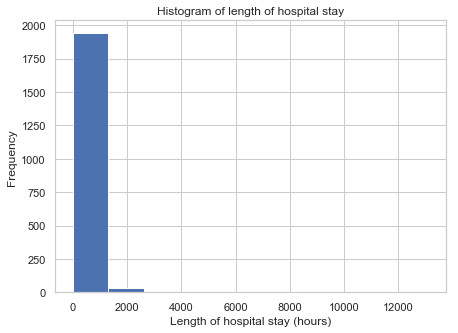

In [9]:
sns.set(style='whitegrid', context='notebook')
plt.figure(figsize=(7,5))
plt.hist(manchester['LengthOfSpellHours'])
plt.xlabel('Length of hospital stay (hours)')
plt.ylabel('Frequency')
plt.title('Histogram of length of hospital stay')
plt.show()

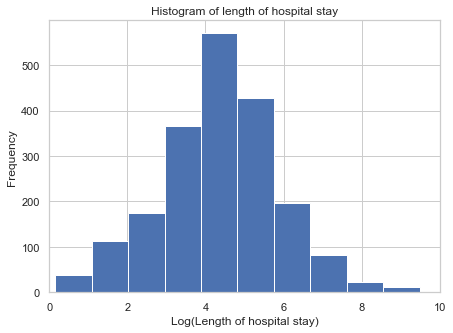

In [10]:
plt.figure(figsize=(7,5))
plt.hist(manchester['LengthOfSpellHours'].apply(np.log))
plt.xlim(0,10)
plt.xlabel('Log(Length of hospital stay)')
plt.ylabel('Frequency')
plt.title('Histogram of length of hospital stay')
plt.show()

In [11]:
manchester['LengthOfSpellHours'].apply(np.log).describe()

count    1999.000000
mean        4.358318
std         1.492568
min         0.157004
25%         3.491952
50%         4.407573
75%         5.248996
max         9.480722
Name: LengthOfSpellHours, dtype: float64

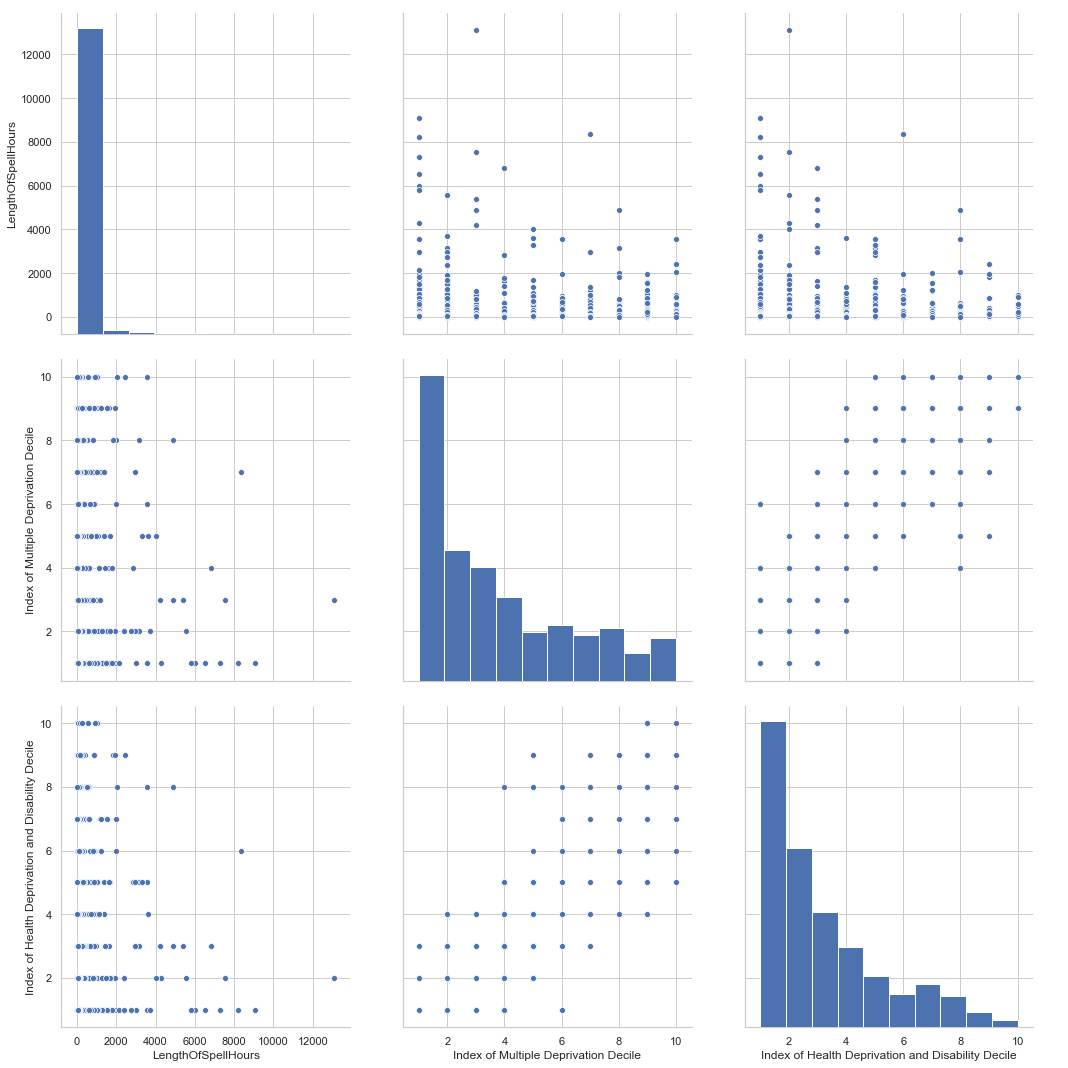

In [12]:
sns.set(style='whitegrid', context='notebook')
sns.pairplot(manchester, size=5)
plt.tight_layout()
plt.show()

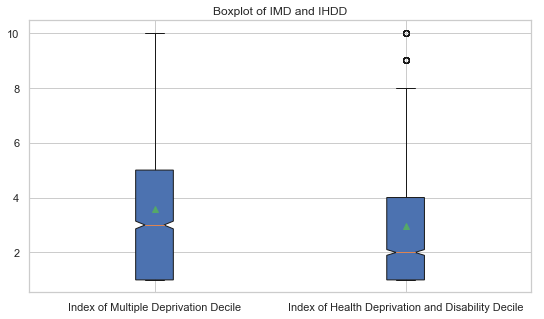

In [13]:
plt.figure(figsize=(9,5))
plt.boxplot([manchester['Index of Multiple Deprivation Decile'],manchester['Index of Health Deprivation and Disability Decile']], labels=['Index of Multiple Deprivation Decile', 'Index of Health Deprivation and Disability Decile'],notch=True, showmeans=True,patch_artist=True)
plt.title('Boxplot of IMD and IHDD')
plt.show()

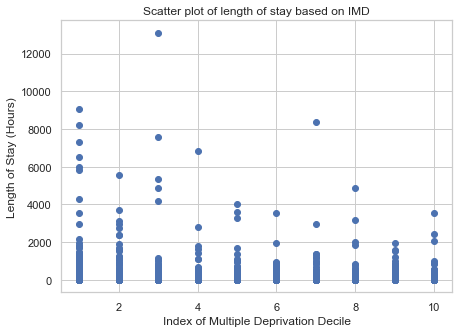

In [14]:
plt.figure(figsize=(7,5))
x = manchester['Index of Multiple Deprivation Decile']
y = manchester['LengthOfSpellHours']
plt.scatter(x, y)
plt.xlabel('Index of Multiple Deprivation Decile')
plt.ylabel('Length of Stay (Hours)')
plt.title('Scatter plot of length of stay based on IMD')
plt.show()

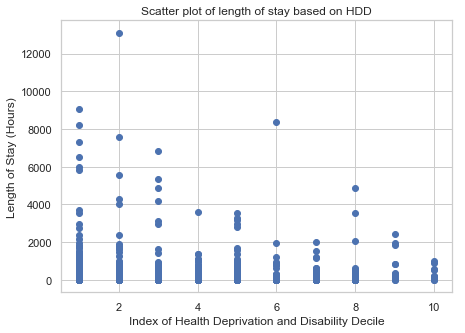

In [15]:
plt.figure(figsize=(7,5))
x = manchester['Index of Health Deprivation and Disability Decile']
y = manchester['LengthOfSpellHours']
plt.scatter(x, y)
plt.xlabel('Index of Health Deprivation and Disability Decile')
plt.ylabel('Length of Stay (Hours)')
plt.title('Scatter plot of length of stay based on HDD')
plt.show()

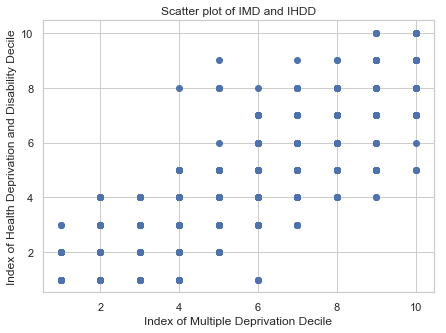

In [16]:
plt.figure(figsize=(7,5))
x = manchester['Index of Multiple Deprivation Decile']
y = manchester['Index of Health Deprivation and Disability Decile']
plt.scatter(x, y)
plt.xlabel('Index of Multiple Deprivation Decile')
plt.ylabel('Index of Health Deprivation and Disability Decile')
plt.title('Scatter plot of IMD and IHDD')
plt.show()

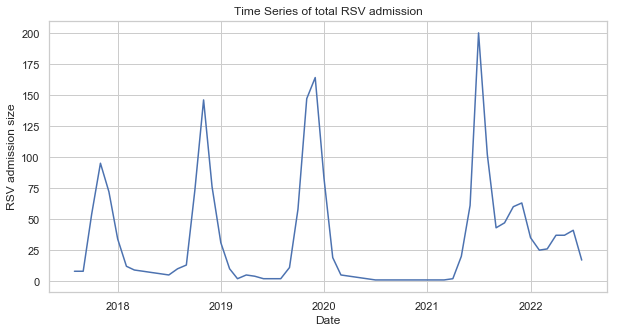

In [17]:
man_whole = manchester.groupby(['YearMonth']).size() # Count the number of cases per month
man_whole.index = man_whole.index.to_timestamp()
plt.figure (figsize=(10,5))
plt.plot(man_whole)
plt.title('Time Series of total RSV admission')
plt.xlabel('Date')
plt.ylabel('RSV admission size')
plt.show()
plt.close()

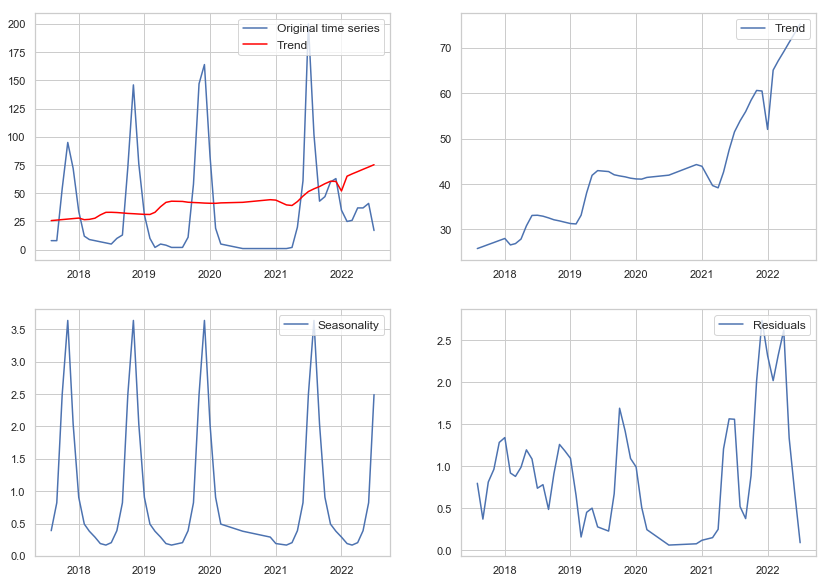

In [18]:
# time series analysis
mul = seasonal_decompose(man_whole, model='multiplicative', extrapolate_trend='freq', period=12)
df_reconstructed = pd.concat([mul.seasonal, mul.trend, mul.resid, mul.observed], axis=1)
df_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']
# Set frequency using period in seasonal_decompose()
trend_estimate    = mul.trend
periodic_estimate = mul.seasonal
residual          = mul.resid
# Plot the time-df components
plt.figure(figsize=(14,10))
plt.subplot(221)
plt.plot(man_whole,label='Original time series')
plt.plot(trend_estimate ,label='Trend' , color='red')
plt.legend(loc=1,fontsize=12)
plt.subplot(222)
plt.plot(trend_estimate,label='Trend')
plt.legend(loc=1,fontsize=12)
plt.subplot(223)
plt.plot(periodic_estimate,label='Seasonality')
plt.legend(loc=1,fontsize=12)
plt.subplot(224)
plt.plot(residual,label='Residuals')
plt.legend(loc=1,fontsize=12)
plt.rcParams.update({'figure.figsize': (14,10)})
# plt.tight_layout()
# plt.savefig('decomposition.png')

## Machine Learning


### IMD + HDD ~ Length of Stay
1. Liear regression
2. Decision Tree
3. Random Forest

In [19]:
x = pd.DataFrame(manchester[['Index of Multiple Deprivation Decile','Index of Health Deprivation and Disability Decile']])
y = np.log(np.array(manchester['LengthOfSpellHours']))
train_X,test_X,train_y,test_y=train_test_split(x,y,train_size=0.8)

In [20]:
np.sqrt(np.mean((test_y-np.mean(test_y))**2))

1.4243074358757029

In [21]:
import statsmodels.api as sm
X2 = sm.add_constant(train_X)
est = sm.OLS(train_y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.4801
Date:                Wed, 14 Sep 2022   Prob (F-statistic):              0.619
Time:                        09:40:32   Log-Likelihood:                -2925.8
No. Observations:                1599   AIC:                             5858.
Df Residuals:                    1596   BIC:                             5874.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

In [22]:
# Linear Regression
regr = LinearRegression()
regr = regr.fit(train_X, train_y)
test_y_pred_lr = regr.predict(test_X)

mae = np.sqrt(np.mean((test_y_pred_lr - test_y)**2))
print(mae)

1.4283144649525172


In [23]:
regr.coef_

array([-0.00617214, -0.00905231])

In [24]:
regr.intercept_

4.395933177287214

In [25]:
# Decision Tree
tree = DecisionTreeRegressor(max_depth=5)
tree.fit(train_X, train_y)
test_y_pred_dt = tree.predict(test_X)

errors = np.sqrt(np.mean((test_y_pred_dt - test_y)**2))
print(errors)

1.441519564846486


In [26]:
# Random Forest
forest = RandomForestRegressor()
forest.fit(train_X, train_y)
test_y_pred_rf = forest.predict(test_X)

errors = np.sqrt(np.mean((test_y_pred_rf - test_y)**2))
print(np.mean(errors))

1.475169889424711


In [27]:
forest.feature_importances_

array([0.46540901, 0.53459099])

## IMD/HDD ~ Proportion
### IMD ~ Proportion of RSV admission

In [28]:
dictIMD = greaterManDF['POPULATION'].groupby(greaterManDF['IMD']).sum()
print('Population in each IMD: ', dictIMD)
print('\n')
print('Number of admission in each IMD:\n', manchester.groupby(['Index of Multiple Deprivation Decile']).size())

Population in each IMD:  IMD
1     675009
2     414225
3     329967
4     253063
5     202514
6     175220
7     181432
8     200730
9     178762
10    141093
Name: POPULATION, dtype: int64


Number of admission in each IMD:
 Index of Multiple Deprivation Decile
1     673
2     287
3     251
4     185
5     107
6     122
7     101
8     117
9      62
10     94
dtype: int64


In [29]:
# Get proportion of RSV admission in each IMD
x_IMD = list(manchester.groupby(['Index of Multiple Deprivation Decile']).size().index)
y_IMD = list(manchester.groupby(['Index of Multiple Deprivation Decile']).size())
for i in range(len(x_IMD)):
    y_IMD[i] = round(y_IMD[i]/dictIMD[x_IMD[i]]*100000,4)
print('x: ', x_IMD)
print('y: ', y_IMD)

x:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
y:  [99.7024, 69.286, 76.0682, 73.1043, 52.8359, 69.6268, 55.6682, 58.2873, 34.683, 66.6227]


In [30]:
print(np.mean(dictIMD))
print(np.mean(manchester.groupby(['Index of Multiple Deprivation Decile']).size()))
np.mean(y_IMD)

275201.5
199.9


65.58848

Function: y = x^-1.73+65.41


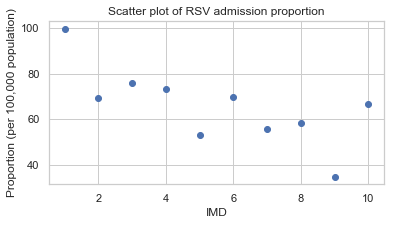

In [31]:
def fund(x, a, b):
    return x**a + b
plt.figure(figsize=(6,3))
plt.scatter(x_IMD, y_IMD)
popt, pcov = curve_fit(fund, x_IMD, y_IMD)
print('Function: y = x^{}+{}'.format(round(popt[0],2), round(popt[1],2)))
x2 = np.linspace(0, 9, 50)
y2 = [fund(i, popt[0],popt[1]) for i in x2]
# plt.plot(x2, y2,'r--')
plt.title('Scatter plot of RSV admission proportion')
plt.xlabel('IMD')
plt.ylabel('Proportion (per 100,000 population)')
plt.show()

Function: y = x^-4.03+87.73


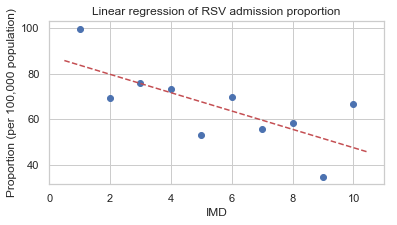

In [32]:
# Linear Regression
def fund(x, a, b):
    return x*a + b
plt.figure(figsize=(6,3))
plt.scatter(x_IMD, y_IMD)
popt, pcov = curve_fit(fund, x_IMD, y_IMD)
print('Function: y = x^{}+{}'.format(round(popt[0],2), round(popt[1],2)))
x2 = np.linspace(0.5, 10.5, 50)
y2 = [fund(i, popt[0],popt[1]) for i in x2]
plt.plot(x2, y2,'r--')
plt.title('Linear regression of RSV admission proportion')
plt.xlabel('IMD')
plt.ylabel('Proportion (per 100,000 population)')
plt.show()

In [33]:
test_y_pred_IMD = np.dot(popt[0],x_IMD)+popt[1]
np.sqrt(np.mean((test_y_pred_IMD-y_IMD)**2))

11.37153761864483

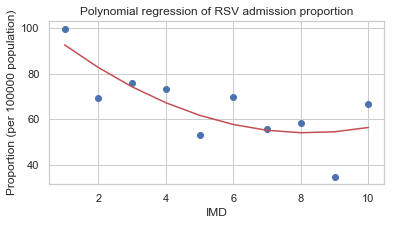

In [34]:
poly_reg = PolynomialFeatures(degree=2)
x_poly = poly_reg.fit_transform(pd.DataFrame(x_IMD).values.reshape(-1,1))

reg = LinearRegression()
reg.fit(x_poly, y_IMD)

plt.figure(figsize=(6,3))
plt.scatter(x_IMD, y_IMD)
plt.plot(x_IMD, reg.predict(x_poly), 'r')
plt.title('Polynomial regression of RSV admission proportion')
plt.xlabel('IMD')
plt.ylabel('Proportion (per 100000 population)')
plt.show()

In [35]:
model = np.poly1d(np.polyfit(x_IMD, y_IMD, 2))
print(model)

      2
0.74 x - 12.17 x + 104


In [36]:
np.sqrt(np.mean((reg.predict(x_poly)-y_IMD)**2))

10.019838671096457

### HDD ~ Proportion of RSV admission

In [37]:
dictHDD = greaterManDF['POPULATION'].groupby(greaterManDF['IHDD']).sum()
print('Population in each IHDD: ', dictHDD)
print('\n')
print('Number of admission in each HDD:\n', manchester.groupby(['Index of Health Deprivation and Disability Decile']).size())

Population in each IHDD:  IHDD
1     763680
2     548567
3     412297
4     300338
5     246737
6     186476
7     158128
8      87159
9      37473
10     11160
Name: POPULATION, dtype: int64


Number of admission in each HDD:
 Index of Health Deprivation and Disability Decile
1     709
2     416
3     267
4     186
5     118
6      77
7     101
8      73
9      36
10     16
dtype: int64


In [38]:
# Get proportion of RSV admission in each HDD
x_HDD = list(manchester.groupby(['Index of Health Deprivation and Disability Decile']).size().index)
y_HDD = list(manchester.groupby(['Index of Health Deprivation and Disability Decile']).size())
for i in range(len(x_HDD)):
    y_HDD[i] = round(y_HDD[i]/dictHDD[x_HDD[i]]*100000,4)
print('x: ', x_HDD)
print('y: ', y_HDD)

x:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
y:  [92.8399, 75.8339, 64.7591, 61.9302, 47.8242, 41.2922, 63.8723, 83.755, 96.0692, 143.3692]


In [39]:
print(np.mean(dictHDD))
print(np.mean(manchester.groupby(['Index of Health Deprivation and Disability Decile']).size()))
np.mean(y_HDD)

275201.5
199.9


77.15452

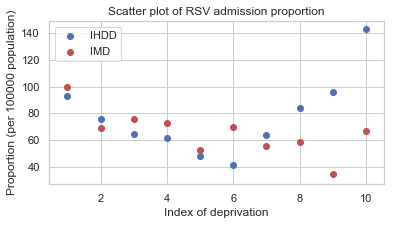

In [40]:
plt.figure(figsize=(6,3))
plt.scatter(x_HDD, y_HDD,color='b',label='IHDD')
plt.scatter(x_IMD,y_IMD,color='r',label='IMD')
plt.title('Scatter plot of RSV admission proportion')
plt.xlabel('Index of deprivation')
plt.ylabel('Proportion (per 100000 population)')
plt.legend()
plt.show()

Function: y = x^4.19+54.13


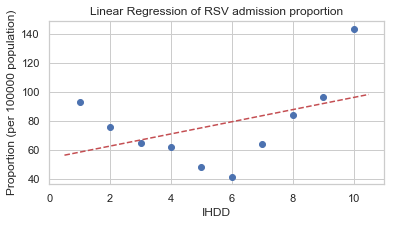

In [41]:
# Linear Regression
def fund(x, a, b):
    return x*a + b
plt.figure(figsize=(6,3))
plt.scatter(x_HDD, y_HDD)
popt, pcov = curve_fit(fund, x_HDD, y_HDD)
print('Function: y = x^{}+{}'.format(round(popt[0],2), round(popt[1],2)))
x2 = np.linspace(0.5, 10.5, 50)
y2 = [fund(i, popt[0],popt[1]) for i in x2]
plt.plot(x2, y2,'r--')
plt.title('Linear Regression of RSV admission proportion')
plt.xlabel('IHDD')
plt.ylabel('Proportion (per 100000 population)')
plt.show()

In [42]:
test_y_pred_HDD = np.dot(popt[0],x_HDD)+popt[1]
np.sqrt(np.mean((test_y_pred_HDD-y_HDD)**2))

25.092063111923732

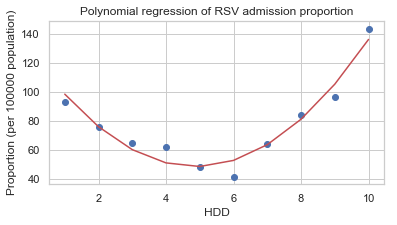

In [43]:
poly_reg = PolynomialFeatures(degree=2)
x_poly = poly_reg.fit_transform(pd.DataFrame(x_HDD).values.reshape(-1,1))

reg = LinearRegression()
reg.fit(x_poly, y_HDD)

plt.figure(figsize=(6,3))
plt.scatter(x_HDD, y_HDD)
plt.plot(x_HDD, reg.predict(x_poly), 'r')
plt.title('Polynomial regression of RSV admission proportion')
plt.xlabel('HDD')
plt.ylabel('Proportion (per 100000 population)')
plt.show()

In [44]:
model = np.poly1d(np.polyfit(x_HDD, y_HDD, 2))
print(model)

       2
3.328 x - 32.43 x + 127.4


In [45]:
np.sqrt(np.mean((reg.predict(x_poly)-y_HDD)**2))

6.686715565088735

## IMD/HDD~Size
IMD ~ Size of RSV admission

In [46]:
x_IMD = list(df.groupby(['Index of Multiple Deprivation Decile']).size().index)
y_IMD = [x for x in df.groupby(['Index of Multiple Deprivation Decile']).size()]
print('x: ', x_IMD)
print('y: ', y_IMD)
fit = np.polyfit(np.log(x_IMD), y_IMD, 1)
a = fit[0]
b = fit[1]
print(a,b)

x:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
y:  [675, 288, 251, 185, 108, 122, 101, 120, 63, 94]
-228.75936895938 546.227588871888


In [47]:
np.sqrt(np.mean((y_IMD-np.mean(y_IMD))**2))

172.32066039799173

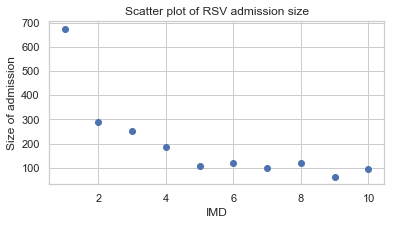

In [48]:
# print('Function: y=log(x)*{}+{}'.format(round(a,2),round(b,2)))
plt.figure(figsize=(6,3))
plt.scatter(x_IMD,y_IMD,color='b',label='train data')
x3 = np.linspace(0, 10, 50)
# plt.plot(x3, np.log(np.array(x3))*a+b)
plt.title('Scatter plot of RSV admission size')
plt.xlabel('IMD')
plt.ylabel('Size of admission')
plt.show()

Function: y=log(x)*-228.76+546.23


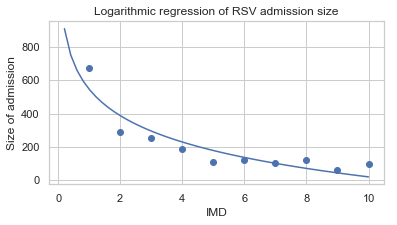

In [49]:
print('Function: y=log(x)*{}+{}'.format(round(a,2),round(b,2)))
plt.figure(figsize=(6,3))
plt.scatter(x_IMD,y_IMD,color='b',label='train data')
x3 = np.linspace(0, 10, 50)
plt.plot(x3, np.log(np.array(x3))*a+b)
plt.title('Logarithmic regression of RSV admission size')
plt.xlabel('IMD')
plt.ylabel('Size of admission')
plt.show()

In [50]:
test_y_pred_IMD = np.log(x_IMD)*a+b
np.sqrt(np.mean((test_y_pred_IMD-y_IMD)**2))

66.23935111733562

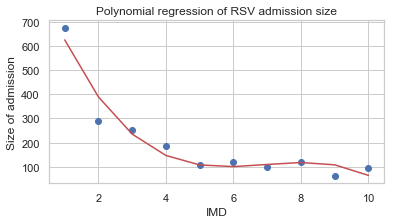

In [51]:
poly_reg = PolynomialFeatures(degree=3)
x_poly = poly_reg.fit_transform(pd.DataFrame(x_IMD).values.reshape(-1,1))

reg = LinearRegression()
reg.fit(x_poly, y_IMD)

plt.figure(figsize=(6,3))
plt.scatter(x_IMD, y_IMD)
plt.plot(x_IMD, reg.predict(x_poly), 'r')
plt.title('Polynomial regression of RSV admission size')
plt.xlabel('IMD')
plt.ylabel('Size of admission')
plt.show()

In [52]:
np.sqrt(np.mean((reg.predict(x_poly)-y_IMD)**2))

42.22500474412077

In [53]:
model = np.poly1d(np.polyfit(x_IMD, y_IMD, 3))
print(model)

        3         2
-2.764 x + 57.61 x - 389 x + 958.4


IMD ~ Size of RSV admission

In [54]:
x_HDD = list(df.groupby(['Index of Health Deprivation and Disability Decile']).size().index)
y_HDD = [x for x in df.groupby(['Index of Health Deprivation and Disability Decile']).size()]
print('x: ', x_HDD)
print('y: ', y_HDD)
fit = np.polyfit(np.log(x_HDD), y_HDD, 1)
a = fit[0]
b = fit[1]
print(a,b)

x:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
y:  [711, 417, 268, 186, 119, 78, 101, 74, 37, 16]
-287.4946124433029 634.9437238880097


In [55]:
np.sqrt(np.mean((y_HDD-np.mean(y_HDD))**2))

205.07854592813945

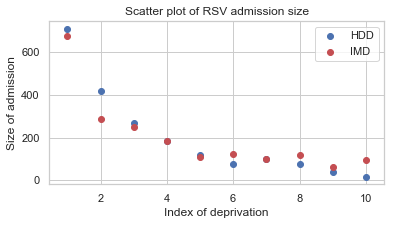

In [56]:
# print('Function: y=log(x)*{}+{}'.format(round(a,2),round(b,2)))
plt.figure(figsize=(6,3))
plt.scatter(x_HDD,y_HDD,color='b',label='HDD')
plt.scatter(x_IMD,y_IMD,color='r',label='IMD')
x3 = np.linspace(0, 10, 50)
# plt.plot(x3, np.log(np.array(x3))*a+b)
plt.title('Scatter plot of RSV admission size')
plt.xlabel('Index of deprivation')
plt.ylabel('Size of admission')
plt.legend()
plt.show()

Function: y=log(x)*-287.49+634.94


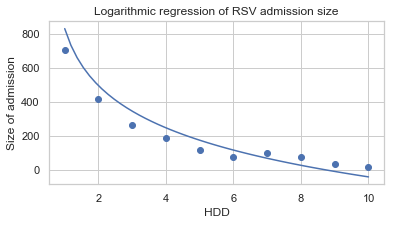

In [57]:
print('Function: y=log(x)*{}+{}'.format(round(a,2),round(b,2)))
plt.figure(figsize=(6,3))
plt.scatter(x_HDD,y_HDD,color='b',label='train data')
x3 = np.linspace(1, 10, 50)
plt.plot(x3, np.log(np.array(x2))*a+b)
plt.title('Logarithmic regression of RSV admission size')
plt.xlabel('HDD')
plt.ylabel('Size of admission')
plt.show()

In [58]:
test_y_pred_HDD = np.log(x_HDD)*a+b
np.sqrt(np.mean((test_y_pred_HDD-y_HDD)**2))

45.681952724229276

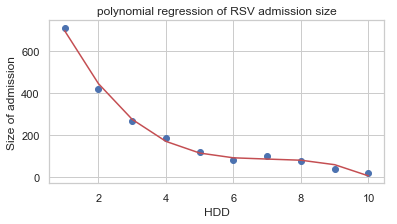

In [59]:
poly_reg = PolynomialFeatures(degree=3)
x_poly = poly_reg.fit_transform(pd.DataFrame(x_HDD).values.reshape(-1,1))

reg = LinearRegression()
reg.fit(x_poly, y_HDD)

plt.figure(figsize=(6,3))
plt.scatter(x_HDD, y_HDD)
plt.plot(x_HDD, reg.predict(x_poly), 'r')
plt.title('polynomial regression of RSV admission size')
plt.xlabel('HDD')
plt.ylabel('Size of admission')
plt.show()

In [60]:
# test_y_pred_HDD = np.log(x_HDD)*a+b
np.sqrt(np.mean((reg.predict(x_poly)-y_HDD)**2))

15.260350532287752

In [61]:
model = np.poly1d(np.polyfit(x_HDD, y_HDD, 3))
print(model)

       3         2
-2.71 x + 57.14 x - 404.6 x + 1046


## Time Series 

In [62]:
# Count RSV admissions per month in each IMD decile
ts_IMD = manchester.groupby(['YearMonth','Index of Multiple Deprivation Decile']).size()
ts_IMD = ts_IMD.unstack('Index of Multiple Deprivation Decile')
ts_IMD = ts_IMD.fillna(value=0).astype(int)
ts_IMD.head()

Index of Multiple Deprivation Decile,1,2,3,4,5,6,7,8,9,10
YearMonth,,,,,,,,,,
2017-08,3,2,2,0,0,0,0,1,0,0
2017-09,3,1,2,0,0,0,1,1,0,0
2017-10,20,9,6,6,1,4,1,4,1,2
2017-11,25,14,11,14,4,6,7,6,4,4
2017-12,26,9,5,11,5,6,1,5,3,1


In [63]:
# Change admission size to proportion for each IMD
d = ts_IMD
for i in range(1,11):
    for j in range(len(ts_IMD)):
        ts_IMD[i][j] = int(ts_IMD[i][j]/dictIMD[i]*100000)
ts_IMD.head()

Index of Multiple Deprivation Decile,1,2,3,4,5,6,7,8,9,10
YearMonth,,,,,,,,,,
2017-08,0,0,0,0,0,0,0,0,0,0
2017-09,0,0,0,0,0,0,0,0,0,0
2017-10,2,2,1,2,0,2,0,1,0,1
2017-11,3,3,3,5,1,3,3,2,2,2
2017-12,3,2,1,4,2,3,0,2,1,0


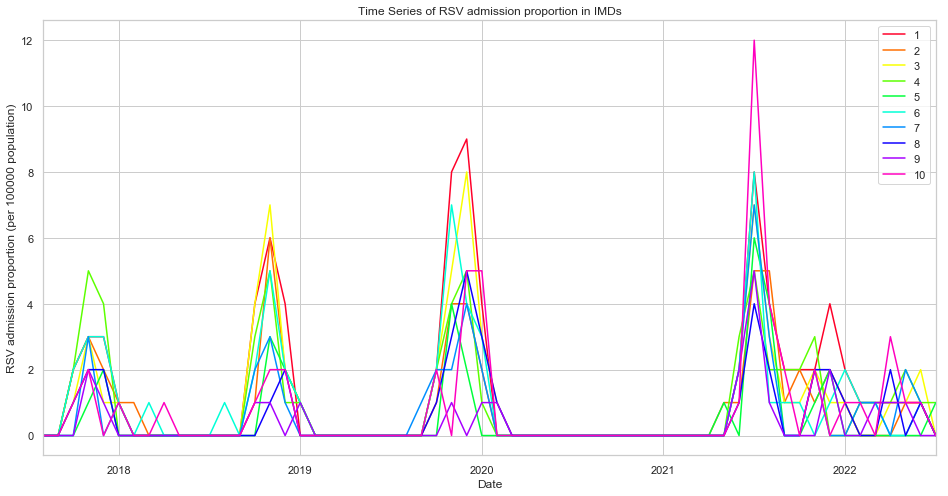

In [64]:
cmap = cm.get_cmap('gist_rainbow')
# cividis, hot, inferno, plasma
ts_IMD.plot(figsize=(16, 8), cmap=cmap)
plt.legend(loc='upperright')
plt.title('Time Series of RSV admission proportion in IMDs')
plt.xlabel('Date')
plt.ylabel('RSV admission proportion (per 100000 population)')
plt.show()

In [65]:
ts_HDD = manchester.groupby(['YearMonth','Index of Health Deprivation and Disability Decile']).size()#Count the number of cases per month in different IMD regions
ts_HDD = ts_HDD.unstack('Index of Health Deprivation and Disability Decile')
ts_HDD = ts_HDD.fillna(value=0).astype(int)
ts_HDD.head()

Index of Health Deprivation and Disability Decile,1,2,3,4,5,6,7,8,9,10
YearMonth,,,,,,,,,,
2017-08,4,3,0,0,0,0,0,1,0,0
2017-09,3,3,0,0,1,1,0,0,0,0
2017-10,21,14,5,3,5,1,1,2,2,0
2017-11,29,18,18,11,3,3,7,4,2,0
2017-12,24,17,11,6,6,2,4,1,1,0


In [66]:
# Change admission size to proportion for each IMD
d = ts_HDD
for i in range(1,11):
    for j in range(len(ts_HDD)):
        ts_HDD[i][j] = int(ts_HDD[i][j]/dictHDD[i]*100000)
ts_HDD.head()

Index of Health Deprivation and Disability Decile,1,2,3,4,5,6,7,8,9,10
YearMonth,,,,,,,,,,
2017-08,0,0,0,0,0,0,0,1,0,0
2017-09,0,0,0,0,0,0,0,0,0,0
2017-10,2,2,1,0,2,0,0,2,5,0
2017-11,3,3,4,3,1,1,4,4,5,0
2017-12,3,3,2,1,2,1,2,1,2,0


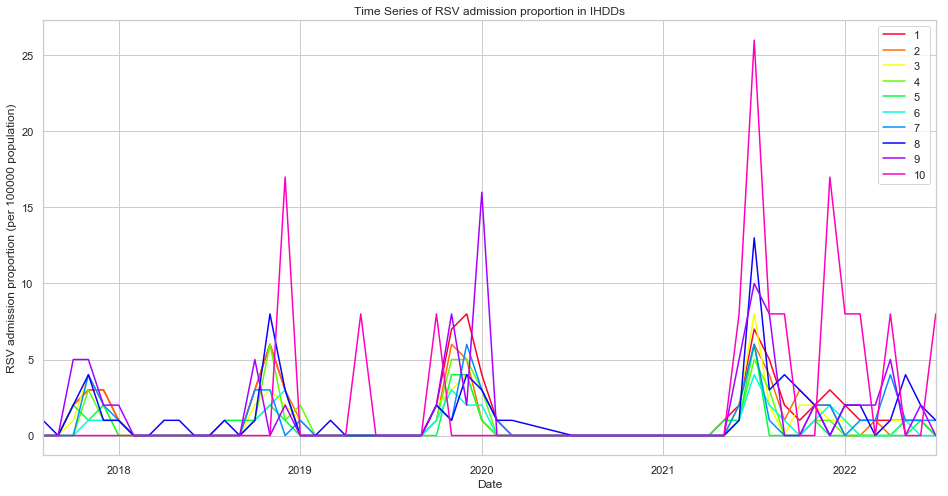

In [67]:
# cividis, hot, inferno, plasma
ts_HDD.plot(figsize=(16, 8), cmap=cmap)
plt.legend(loc='upperright')
plt.title('Time Series of RSV admission proportion in IHDDs')
plt.xlabel('Date')
plt.ylabel('RSV admission proportion (per 100000 population)')
plt.show()